# Text Vector Search

## 0. Prerequisites
Before we begin, we must install the required libraries.

In [ ]:
!pip install sentence-transformers redis

### Install Redis locally (optional)
If you have a Redis db running elsewhere with [Redis Stack](https://redis.io/docs/about/about-stack/) installed, you don't need to run it on this machine. You can skip to the "Connect to Redis server" step.

You can install Redis-Stack locally using the following block:

In [31]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

Starting redis-stack-server, database path /var/lib/redis-stack


In [30]:
# Redis connection params
redis_url = "redis://127.0.0.1:6379"

### Connect to Redis server


Replace the connection params below with your own if you are connecting to an external Redis instance.

In [28]:
# Redis connection params
redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

In [27]:
import redis

# Create Redis client
redis_client = redis.from_url(redis_url)

# Test connection
redis_client.ping()

True

In [11]:
# Clear Redis database (optional)
redis_client.flushdb()

True

## 1. Vector Storage

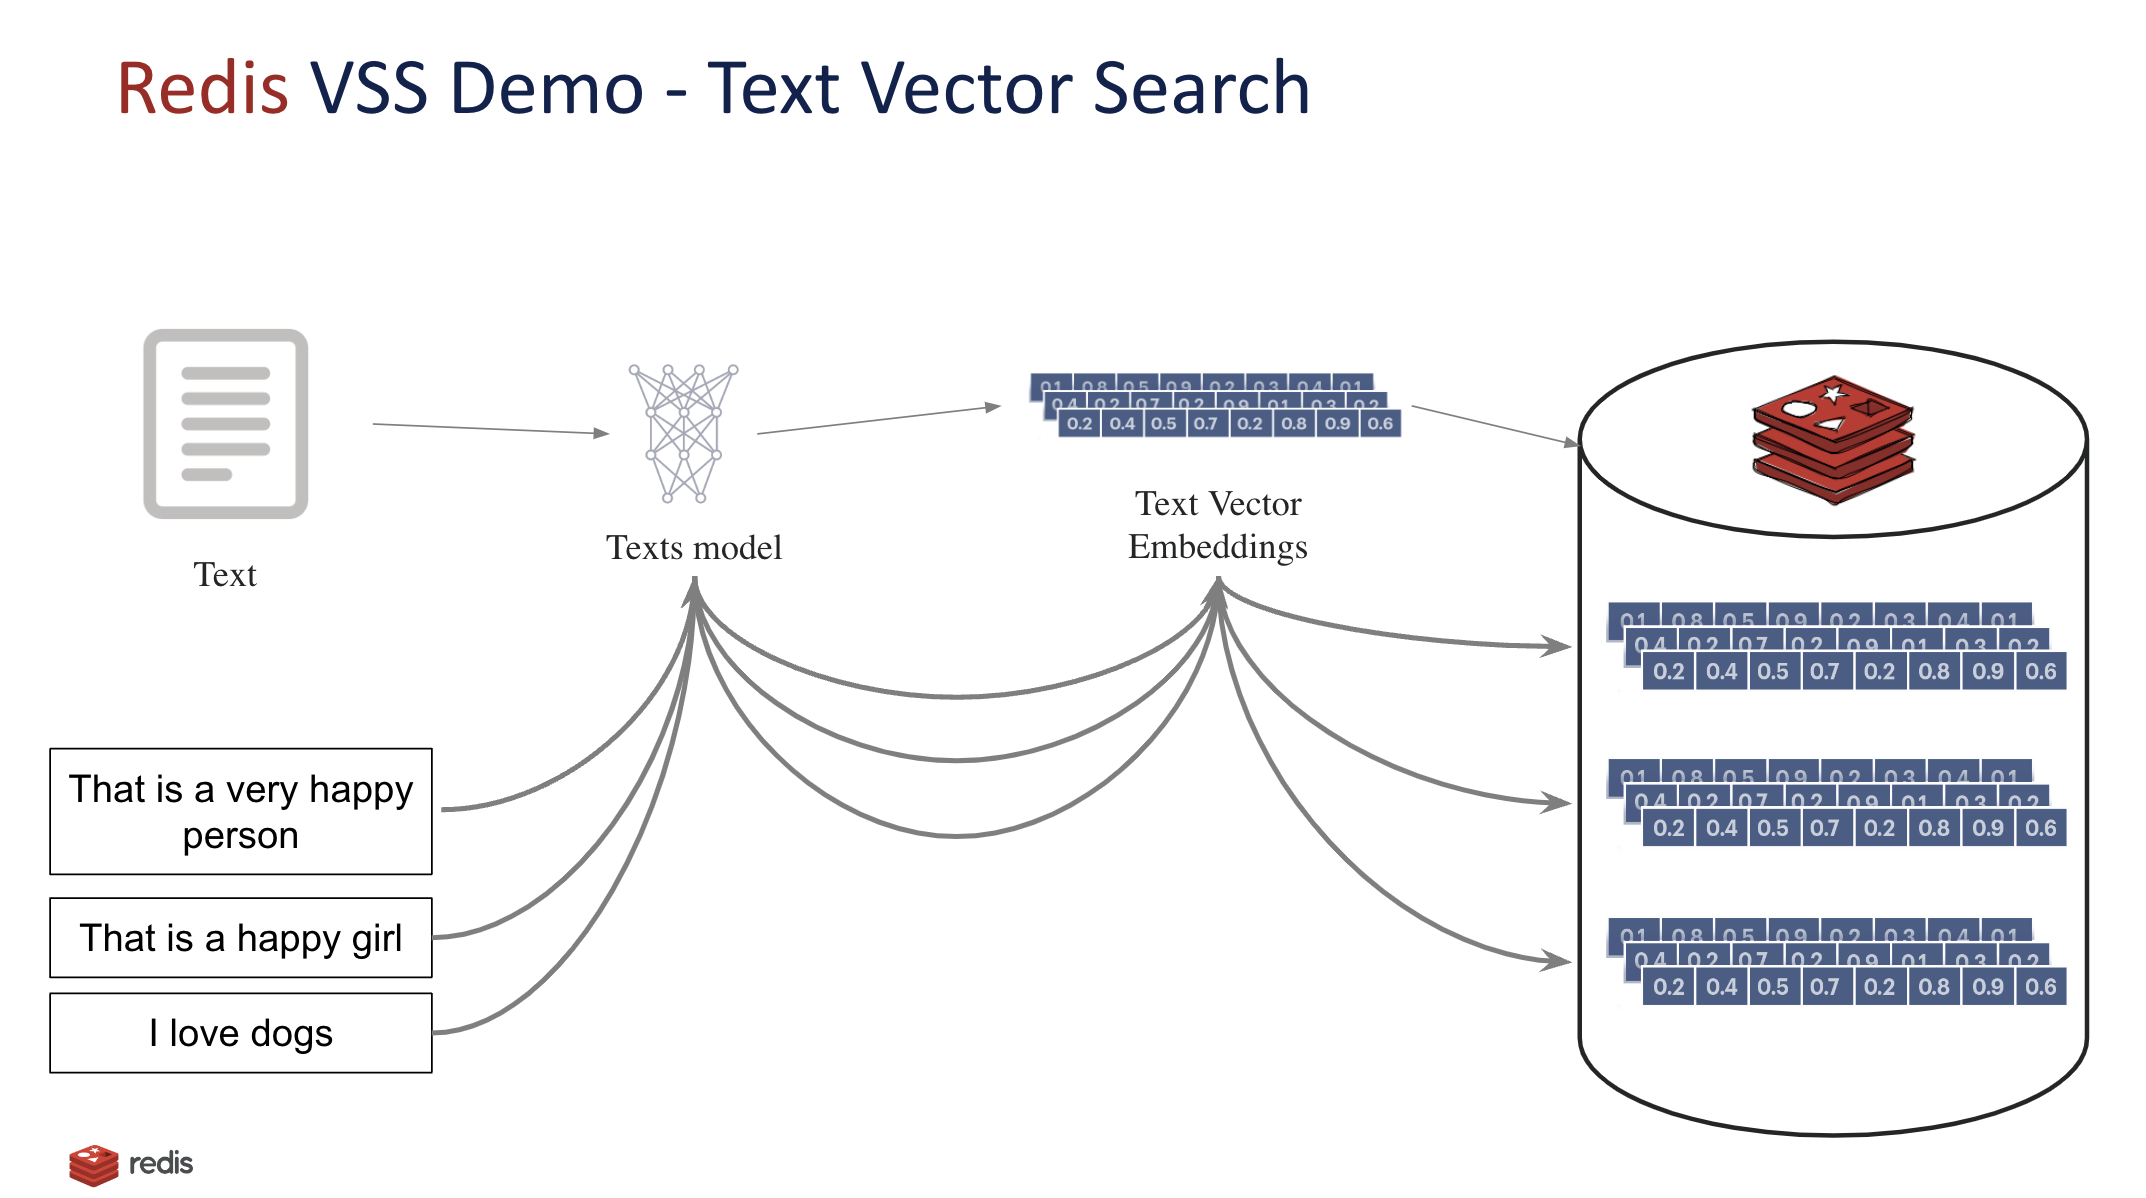

In [12]:
from sentence_transformers import SentenceTransformer
from typing import Generator, List, Any
import numpy as np

# Convert embeddings to bytes for Redis storage
def convert_embedding(emb: List[float]):
  return np.array(emb).astype(np.float32).tobytes()

def generate_text_vectors(text):

   # Bert model from HuggingFace to create text embeddings
   text_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

   # generate text vector
   text_vector = text_model.encode(text).astype(np.float32)
   return text_vector

In [13]:
sentence1 = "That is a very happy person"
sentence2 = "That is a happy girl"
sentence3 = "I love dogs"

In [14]:
vector1 = generate_text_vectors(sentence1)
vector2 = generate_text_vectors(sentence2)
vector3 = generate_text_vectors(sentence3)

In [15]:
# The sentences have been converted to a list of floats (this is a truncated view)
print(vector1[:10])

[-0.01357625  0.00433918  0.00906893  0.03824152  0.04713983  0.00056843
 -0.03855433 -0.00387478  0.05578218  0.03658427]


In [16]:
redis_client.hset('sentence:1', mapping={"text": sentence1, "embedding": convert_embedding(vector1)})
redis_client.hset('sentence:2', mapping={"text": sentence2, "embedding": convert_embedding(vector2)})
redis_client.hset('sentence:3', mapping={"text": sentence3, "embedding": convert_embedding(vector3)})

2

## 2. Vector Indexing
After creating embeddings that represent the sentences and storing them in Redis, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, [check out these docs](https://redis.io/docs/interact/search-and-query/search/vectors/) and [these Redis AI resources](https://github.com/RedisVentures/redis-ai-resources).

**Why do we need to enable search???**
Using Redis for vector similarity search allows us to retrieve chunks of text data that are **similar** or **relevant** to an input question or query. This will be extremely helpful for our sample generative ai / LLM application.

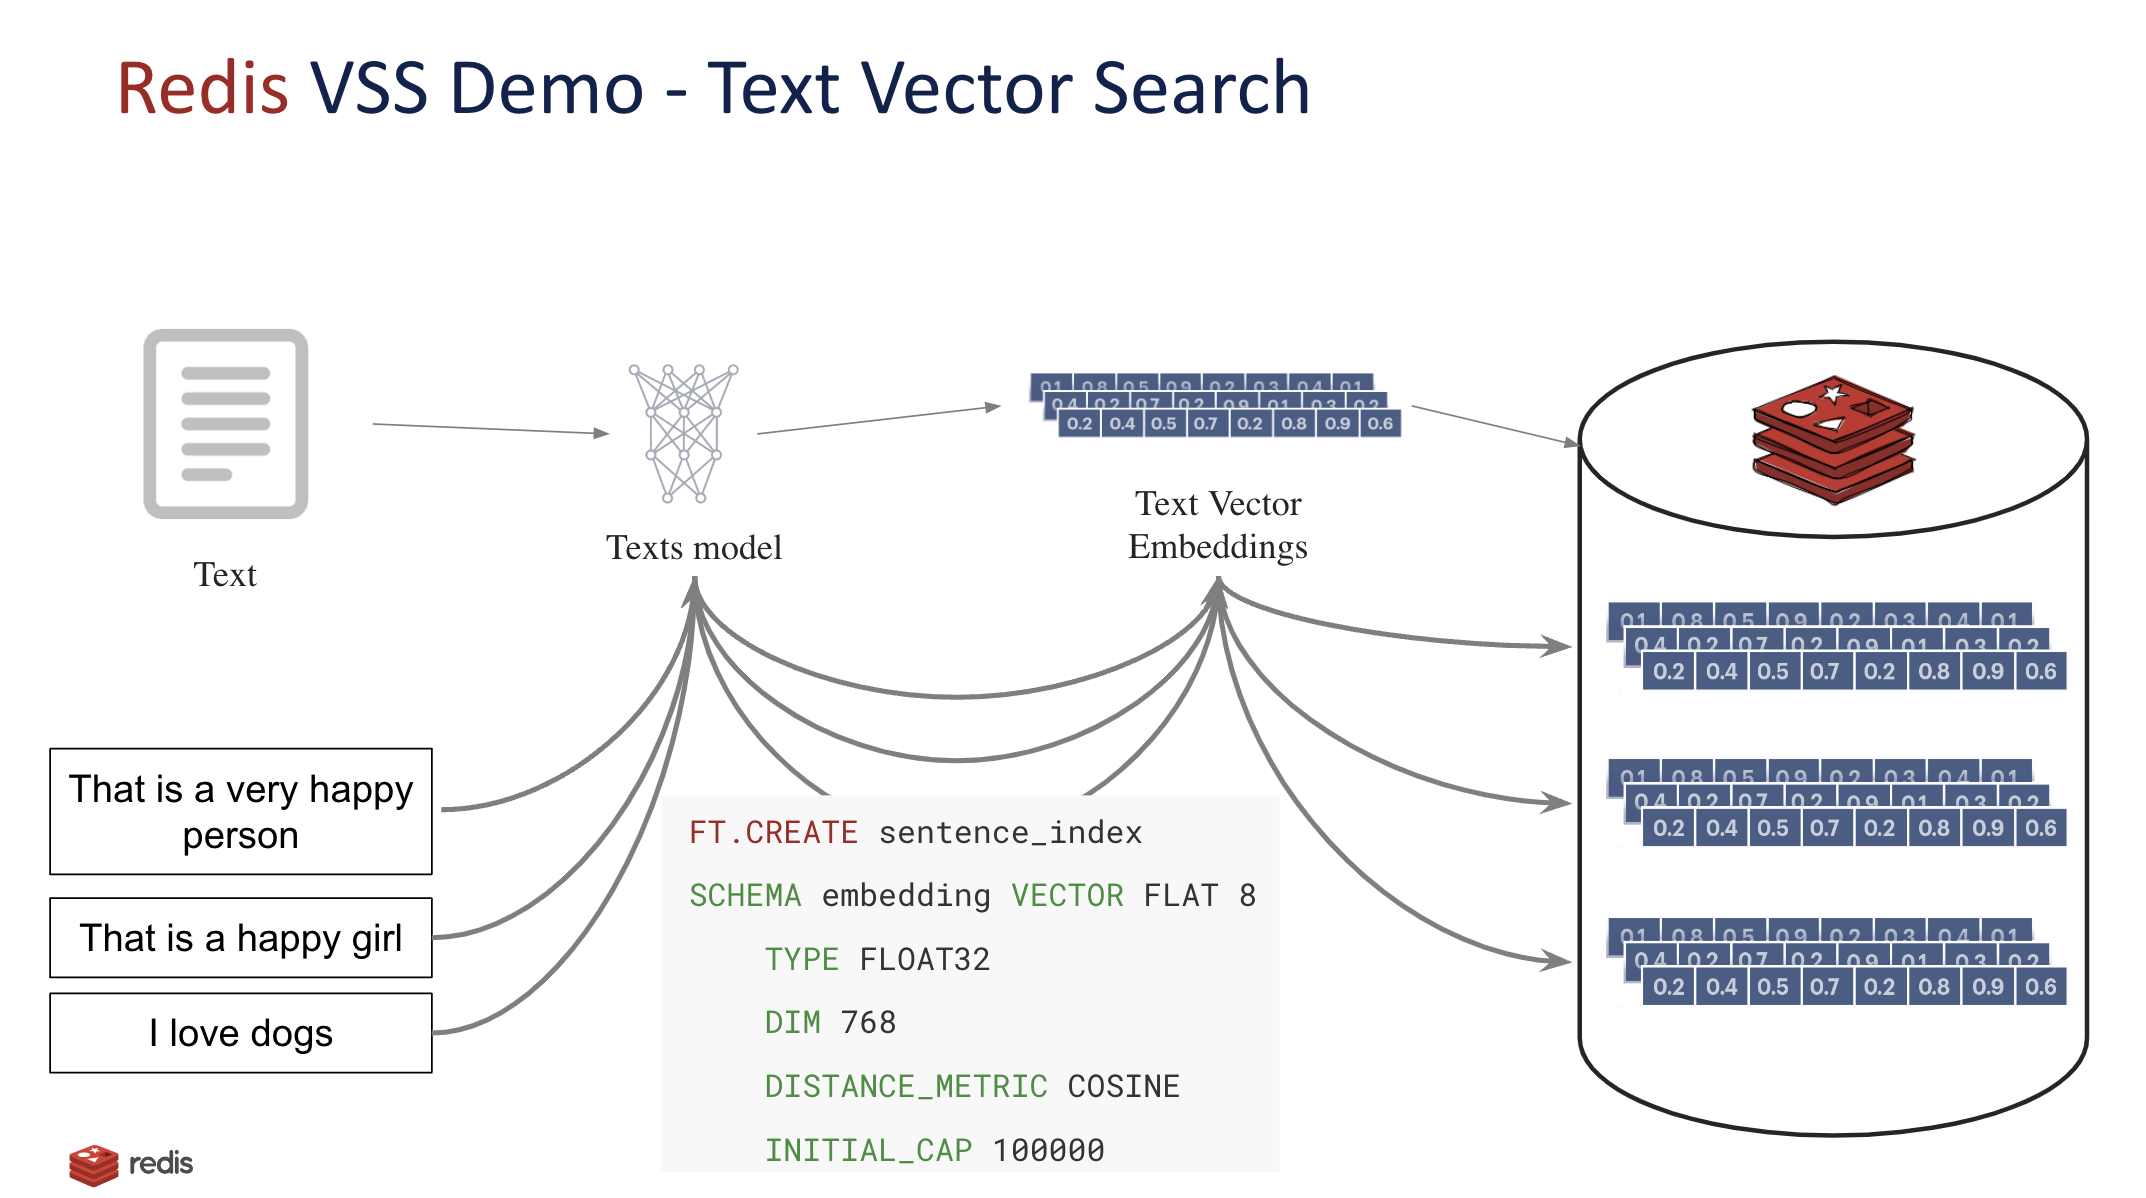

In [17]:
from redis.commands.search.field import (
    NumericField,
    TagField,
    TextField,
    VectorField,
)

from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)

INDEX_NAME = "sentence_index"
PREFIX = "sentence:"
VECTOR_FIELD_NAME = "embedding"
VECTOR_DIMENSIONS = 768
INITIAL_CAP: 100000

# Store vectors in redis and create index
def create_redis_index(
    redis_client: redis.Redis,
    vector_field_name: str = VECTOR_FIELD_NAME,
    index_name: str = INDEX_NAME,
    prefix: list = [PREFIX],
    dim: int = VECTOR_DIMENSIONS,
    initial:int = 100000
  ):

    # Construct index
    try:
        redis_client.ft(index_name).info()
        print("Existing index found. Dropping and recreating the index", flush=True)
        redis_client.ft(index_name).dropindex(delete_documents=False)
    except:
        print("Creating new index", flush=True)

    # Create new index
    redis_client.ft(index_name).create_index(
        (
            VectorField(
                vector_field_name, "FLAT",
                {
                    "TYPE": "FLOAT32",
                    "DIM": dim,
                    "DISTANCE_METRIC": "COSINE",
                    "INITIAL_CAP": initial
                }
            )
        ),
        definition=IndexDefinition(prefix=prefix, index_type=IndexType.HASH)
    )

In [18]:
# Create index
create_redis_index(redis_client)

Creating new index


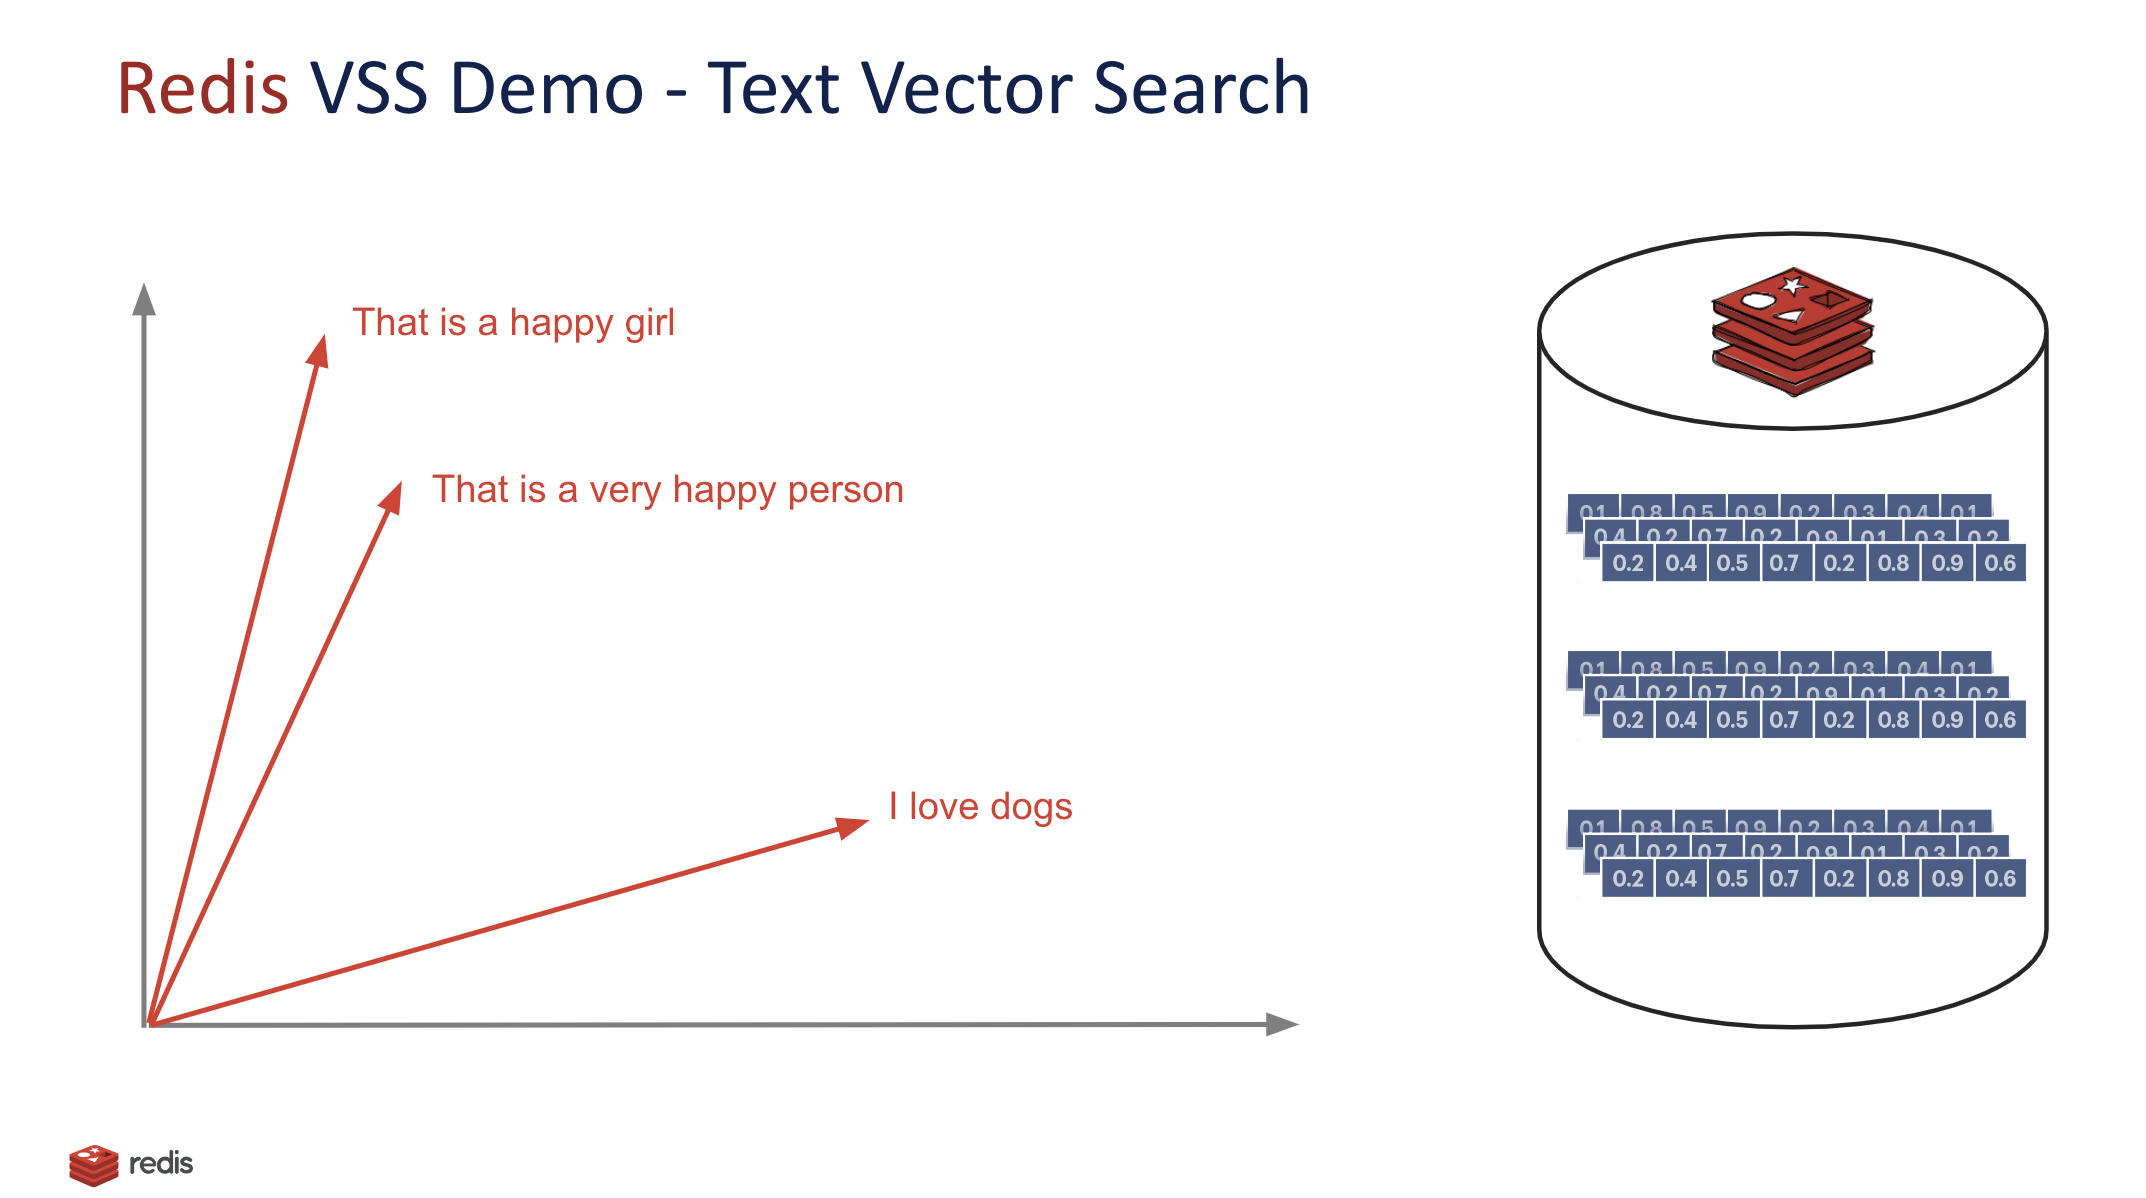

## 3. Vector Querying
Let's create a query sentence and calculate its distance (similarity) with the sentences created previously.

In [19]:
# 1. Create query vector
query_sentence = "That is a happy boy"

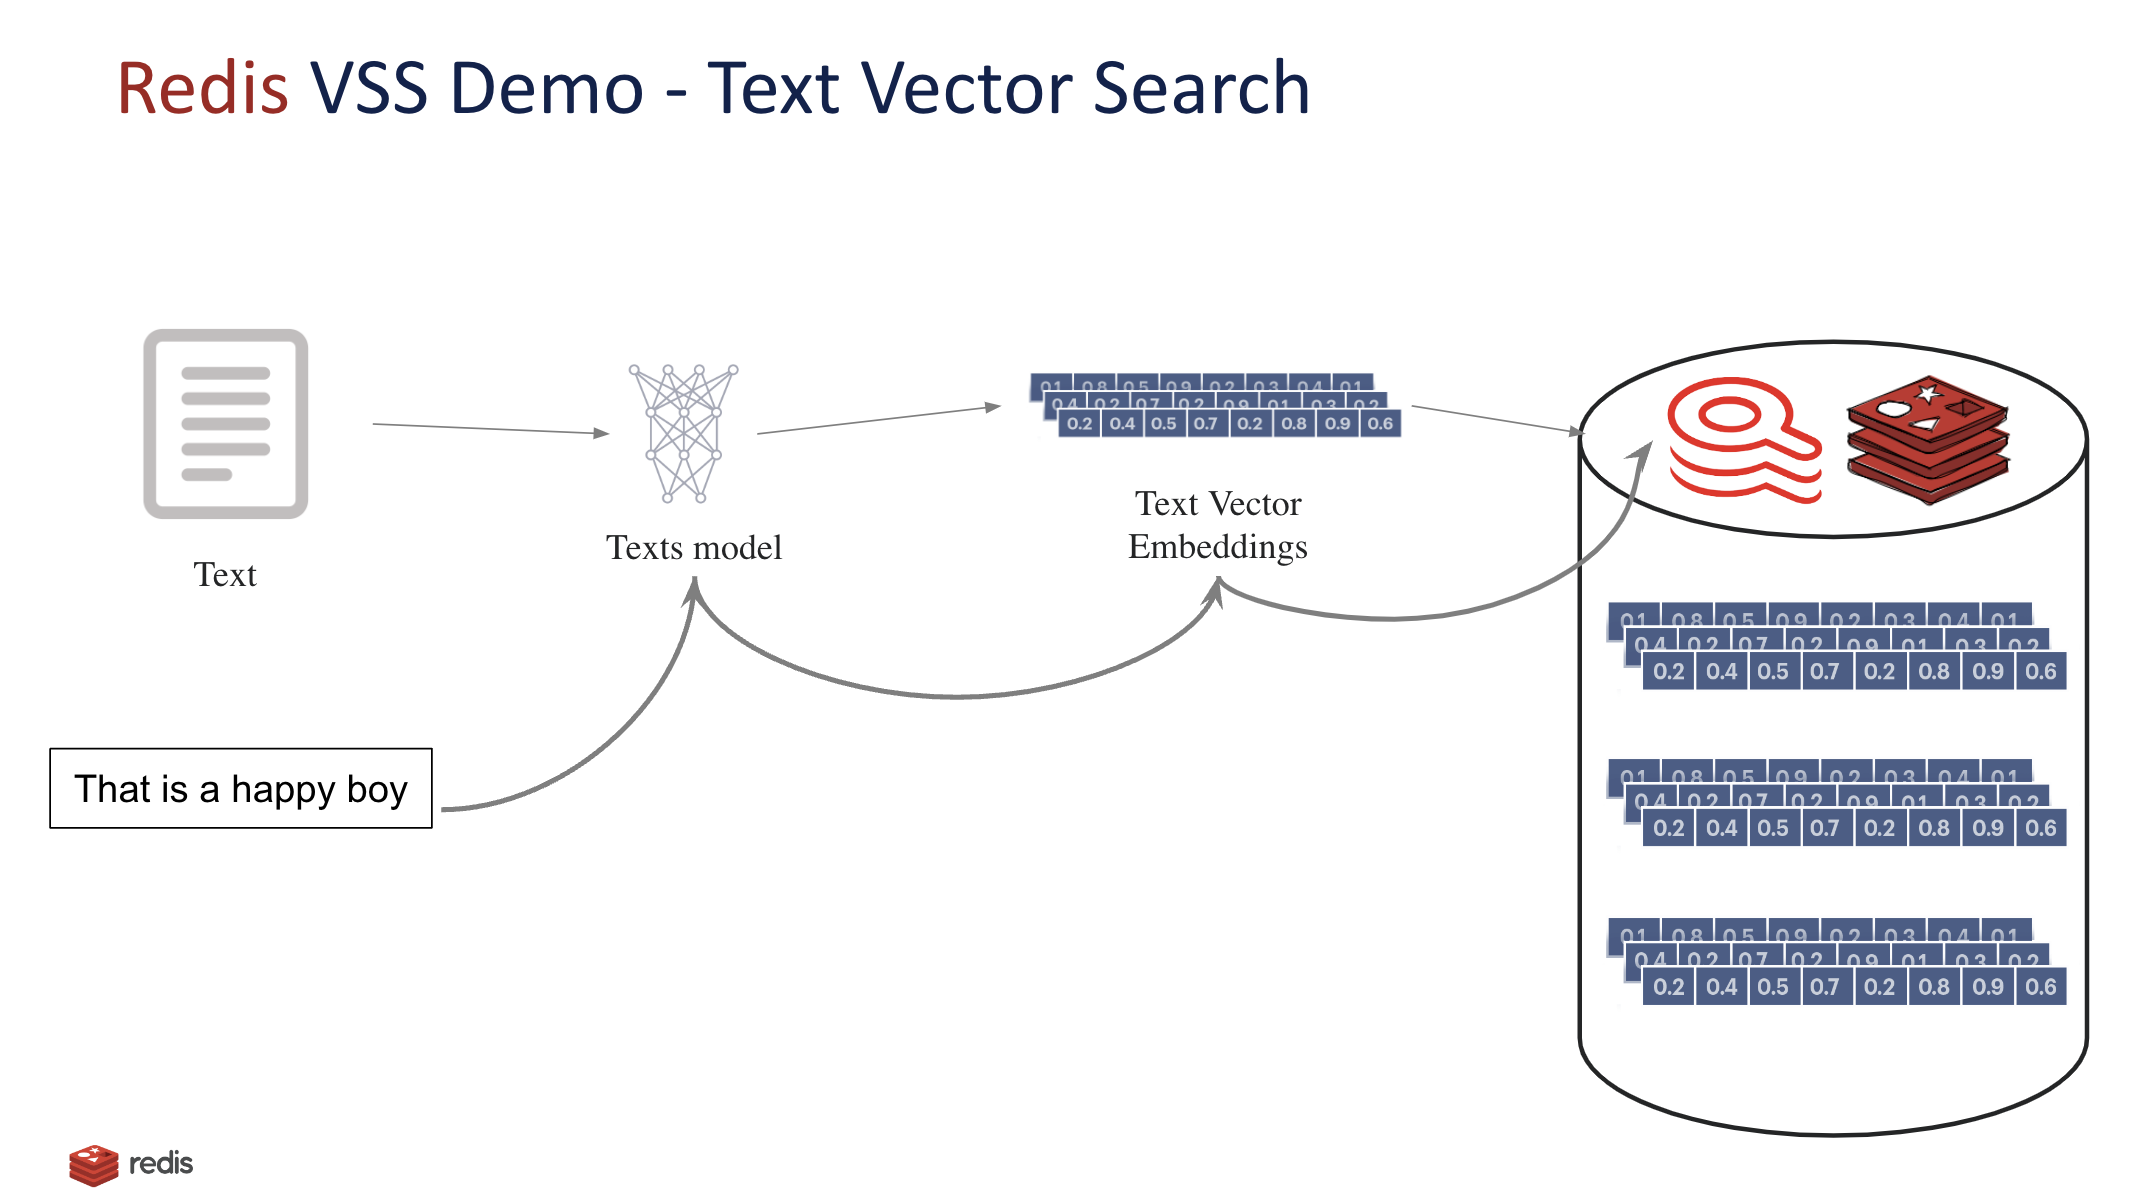

### Define a helper function to perform the KNN similarity search

We define a helper function, `similarity_search`, to create an embedding from the query sentence and compare it to other vectors having the same prefix according to the index created previously.

In [20]:
from redis.commands.search.query import Query
import pandas as pd

# Helper method to perform KNN similarity search in Redis
def similarity_search(query: str, k: int, return_fields: tuple, index_name: str = INDEX_NAME) -> list:
    # create redis query object
    redis_query = (
        Query(f"*=>[KNN {k} @{VECTOR_FIELD_NAME} $embedding AS distance]")
            .sort_by("distance")
            .return_fields(*return_fields)
            .paging(0, k)
            .dialect(2)
    )
    # create embedding from query text
    query_vector = generate_text_vectors(query)

    # execute the search
    results = redis_client.ft(index_name).search(
        redis_query, query_params={"embedding": np.array(query_vector, dtype=np.float32).tobytes()}
    )
    return pd.DataFrame([t.__dict__ for t in results.docs]).drop(columns=["payload"])

In [21]:
# 2. Perform vector similarity search with given query
results = similarity_search(query_sentence, k=3, return_fields=("distance", "text"))
results['score'] = 1 - results['distance'].astype('float64')
display(results.sort_values("score", ascending=False).drop(columns=["distance"]))

,id,text,score
0,sentence:2,That is a happy girl,0.768872
1,sentence:1,That is a very happy person,0.758470
2,sentence:3,I love dogs,0.198088


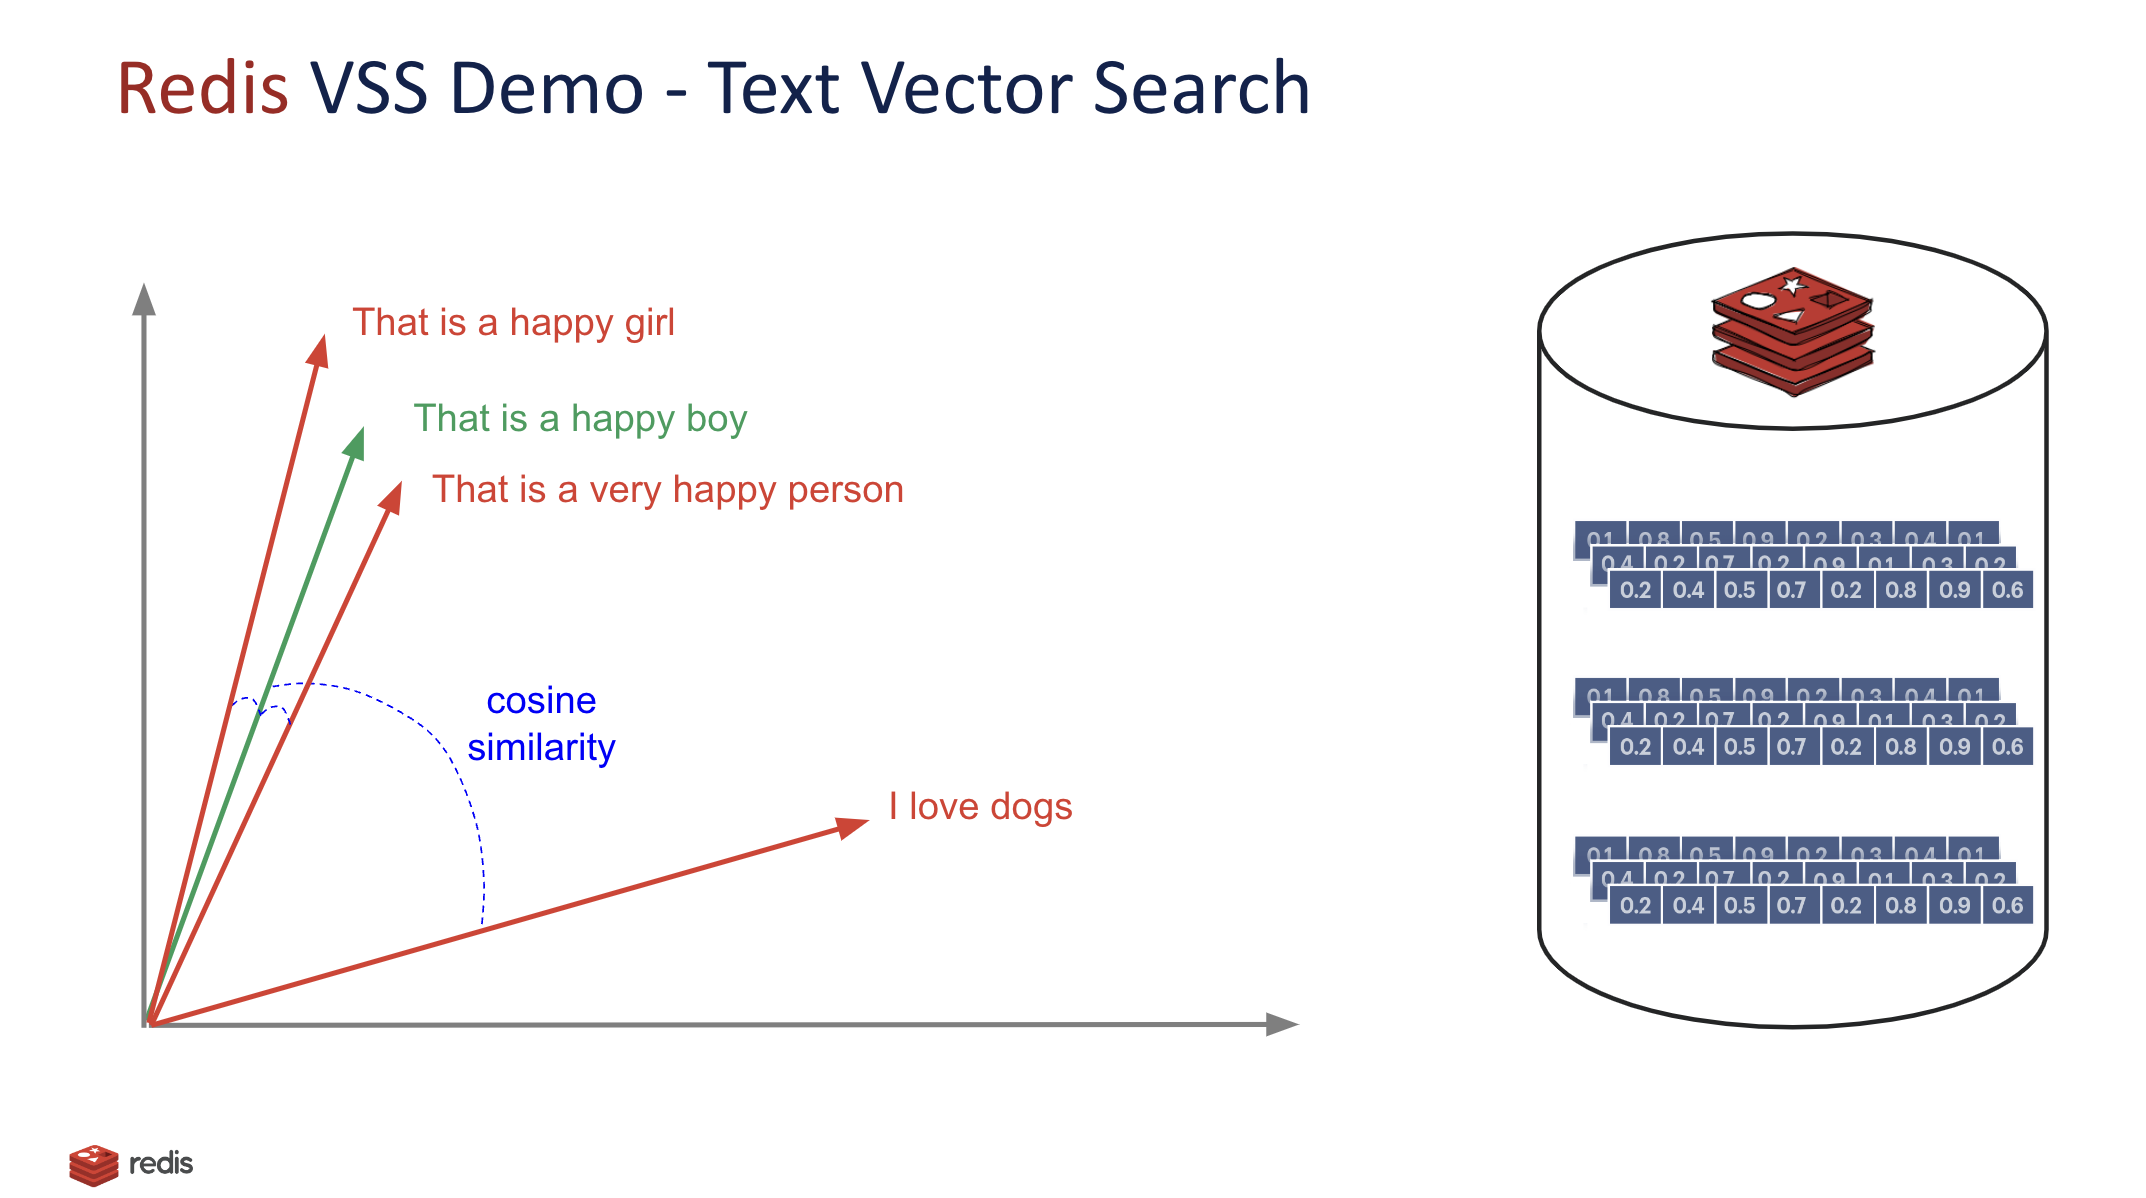